In [3]:
#!pip install segmentation-models-pytorch
#!pip install lightning

import numpy as np
import nibabel as nib
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning as L
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
# introduce fastai loss func
from fastai.losses import *
import torchmetrics

Image File: image_1_slice_66.npy
Image Shape: (512, 512)
Unique Values in Image: [-3024. -1024. -1023. ...   869.   893.   910.]
Label File: label_13_slice_91.npy
Label Shape: (512, 512)
Unique Values in Label: [0.]


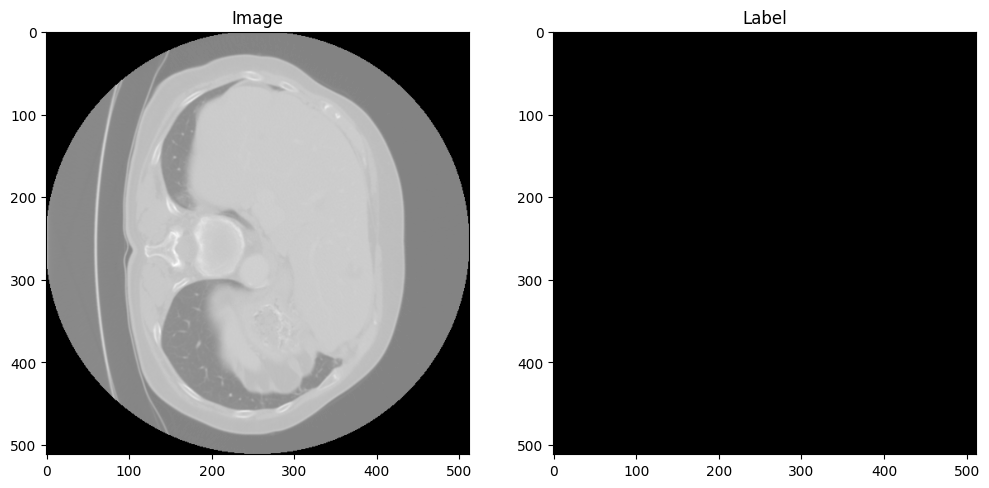

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random


npy_image_dir = '/kaggle/input/npy-dataset/npy_images'
npy_label_dir = '/kaggle/input/npy-dataset/npy_labels'



image_files = os.listdir(npy_image_dir)
label_files = os.listdir(npy_label_dir)


random_index = random.randint(0, len(image_files) - 1)
selected_image_file = image_files[random_index]
selected_label_file = label_files[random_index]


selected_image_path = os.path.join(npy_image_dir, selected_image_file)
selected_label_path = os.path.join(npy_label_dir, selected_label_file)


image = np.load(selected_image_path)
label = np.load(selected_label_path)


image_shape = image.shape
label_shape = label.shape
unique_values_in_image = np.unique(image)
unique_values_in_label = np.unique(label)


print(f"Image File: {selected_image_file}")
print(f"Image Shape: {image_shape}")
print(f"Unique Values in Image: {unique_values_in_image}")
print(f"Label File: {selected_label_file}")
print(f"Label Shape: {label_shape}")
print(f"Unique Values in Label: {unique_values_in_label}")


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(label, cmap='gray')
ax[1].set_title('Label')
plt.show()

In [19]:
len(image_files), len(label_files)

(4, 4)

In [20]:
import os


npy_image_dir = '/kaggle/input/npy-dataset/npy_images'
npy_label_dir = '/kaggle/input/npy-dataset/npy_labels'


image_files = os.listdir(npy_image_dir)
label_files = os.listdir(npy_label_dir)


generated_label_files = {f.replace('image', 'label') for f in image_files}


actual_label_files = set(label_files)


missing_label_files = generated_label_files - actual_label_files


if missing_label_files:
    print("M:")
    for file in missing_label_files:
        print(file)
else:
    print("D")


D


In [21]:
import os
# import numpy as np
# import torch
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


npy_image_dir = '/kaggle/input/npy-dataset/npy_images'
npy_label_dir = '/kaggle/input/npy-dataset/npy_labels'

image_files = sorted(os.listdir(npy_image_dir))
label_files = sorted(os.listdir(npy_label_dir))


train_images, val_images, train_labels, val_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42)

len(train_images), len(val_images), len(train_labels), len(val_labels)

(3, 1, 3, 1)

In [22]:


train_transform = A.Compose([
    # A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    # some CT data seem not well scaled so we use custom Normalize
    ToTensorV2(),
])

val_transform = A.Compose([
    # A.Resize(256, 256),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

def adjust_window(image, window_center, window_width):
    """
    Adjust the window width and level of CT images.
    :param image: Input image array
    :param window_center: Window level (WC).
    :param window_width: Window width (WW).
    :return: Image after adjusting window width and level.
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    return windowed_img

In [23]:

class OrganSegmentationDataset(Dataset):
    def __init__(self, image_files, label_files, transform=None):
        self.image_files = image_files
        self.label_files = label_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(npy_image_dir, self.image_files[idx])
        label_path = os.path.join(npy_label_dir, self.label_files[idx])

        image = np.load(image_path)
        label = np.load(label_path)

        
        window_center = 40
        window_width = 400
        image = adjust_window(image, window_center, window_width)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask'] # Now they are tensors
            image = image.float()
            label = label.long()

        return image.float(), label.long()

In [24]:
import torchmetrics
import fastai.losses
class UNetModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                              in_channels=1, classes=3)
        self.loss_fn = FocalLossFlat(axis=1, gamma=3.5)

        # init metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3)
        self.Dice = torchmetrics.Dice(multiclass=True, num_classes=3)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        # labels = labels 
        loss = self.loss_fn(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        Dice = self.Dice(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)
        self.log('train_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)
        self.log('train_Dice', Dice, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        # labels = labels 
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_accuracy(preds, labels)
        Dice = self.Dice(preds, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)
        self.log('val_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)
        self.log('val_Dice', Dice, on_step=True, on_epoch=True, prog_bar=True, logger=True, enable_graph=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [25]:
train_dataset = OrganSegmentationDataset(train_images, train_labels, transform=train_transform)
val_dataset = OrganSegmentationDataset(val_images, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


model = UNetModel()

# PyTorch LightningTrainer
# trainer = L.Trainer(max_epochs=10)
trainer = L.Trainer(max_epochs=1)

trainer.fit(model, train_loader, val_loader)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s] 
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Unet               | 24.4 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | Dice           | Dice               | 0     
------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.722    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


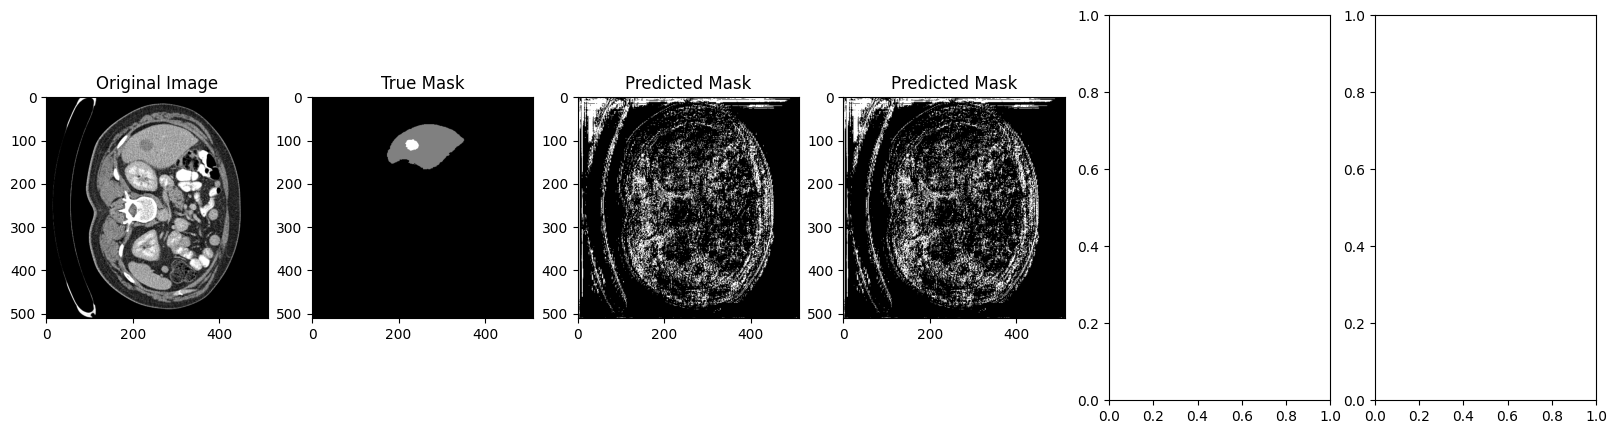

In [26]:
import matplotlib.pyplot as plt
import torch


batch = next(iter(train_loader))
images, masks = batch


image = images[0].unsqueeze(0)  
mask = masks[0]


model.eval()


device = next(model.parameters()).device  
image = image.to(device)


with torch.no_grad():
    prediction = model(image)
    prediction = torch.argmax(prediction, dim=1).squeeze(0).cpu()  


fig, axs = plt.subplots(1, 6, figsize=(20, 5))
axs[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(mask.cpu().numpy(), cmap='gray')
axs[1].set_title('True Mask')
axs[2].imshow(prediction.numpy(), cmap='gray')
axs[2].set_title('Predicted Mask')
axs[3].imshow(prediction.numpy(), cmap='gray')
axs[3].set_title('Predicted Mask')
plt.show()

In [27]:

train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(128, 128),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

def adjust_window(image, window_center, window_width):
    """
    Adjust the window width and level of CT images.
    :param image: Input image array
    :param window_center: Window level (WC).
    :param window_width: Window width (WW).
    :return: Image after adjusting window width and level.
    """
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    # print(windowed_img.dtype) # NOW its float64
    return windowed_img

class MultipleImageDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        image_paths: Image file path list
        label_paths: Label file path list
        transform: Transformation operations applied to images and labels
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = np.load(self.label_paths[idx])

        image = adjust_window(image, window_center=40, window_width=400)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']
            image = image.float()
            label = label.long()
        else:
            image = torch.from_numpy(image).unsqueeze(0).float()  # 添加通道维度
            label = torch.from_numpy(label).long()

        label = label.long()
        # normalize image here based on its value accordingly
        image = (image - image.min()) / (image.max() - image.min())
        # print(image.unique())
        return image.float(), label.long()


image_paths = [
    '/kaggle/input/npy-dataset/npy_images/image_1_slice_66.npy',
    '/kaggle/input/npy-dataset/npy_images/image_13_slice_91.npy',
    '/kaggle/input/npy-dataset/npy_images/image_10_slice_345.npy',
    '/kaggle/input/npy-dataset/npy_images/image_2_slice_406.npy'
]
label_paths = [
    '/kaggle/input/npy-dataset/npy_labels/label_1_slice_66.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_13_slice_91.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_10_slice_345.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_2_slice_406.npy',
]


val_image_paths = [
    '/kaggle/input/npy-dataset/npy_images/image_1_slice_66.npy',
    '/kaggle/input/npy-dataset/npy_images/image_13_slice_91.npy',
    '/kaggle/input/npy-dataset/npy_images/image_10_slice_345.npy',
    '/kaggle/input/npy-dataset/npy_images/image_2_slice_406.npy'
]
val_label_paths = [
    '/kaggle/input/npy-dataset/npy_labels/label_1_slice_66.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_13_slice_91.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_10_slice_345.npy',
    '/kaggle/input/npy-dataset/npy_labels/label_2_slice_406.npy',
]




def plot_images(original, mask, prediction, epoch):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title('Prediction')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()



class UNetTestModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=1,
            classes=3
            ) 
        self.loss_fn = FocalLoss()

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3, ignore_index=0)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3, ignore_index=0)
        self.Dice = torchmetrics.Dice(multiclass=True, num_classes=3, ignore_index=0)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        # labels = labels 
        loss = self.loss_fn(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        Dice = self.Dice(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_Dice', Dice, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_accuracy(preds, labels)
        Dice = self.Dice(preds, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_Dice', Dice, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    # def on_training_epoch_end(self, outputs):
    #     self.on_epoch_end()

    # def on_epoch_end(self):
    #     
    #     print("on_epoch_end")
    #     original = np.load(self.image_path)
    #     mask = np.load(self.label_path)

    #     
    #     original = original[None, None, :, :]  
    #     mask = mask[None, None, :, :]  

    #     # Tensor
    #     image_tensor = torch.from_numpy(original).float().to(self.device)

    #     
    #     with torch.no_grad():
    #         prediction = self.forward(image_tensor)
    #         prediction = torch.argmax(prediction, dim=1).squeeze(0).cpu().numpy()

    #     
    #     plot_images(original.squeeze(), mask.squeeze(), prediction, self.current_epoch)

dataset = MultipleImageDataset(image_paths, label_paths, transform=train_transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)
val_dataset = MultipleImageDataset(val_image_paths, val_label_paths, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

torch.Size([1, 128, 128]) torch.Size([128, 128])
torch.float32 torch.int64
tensor(0.) tensor(1.)
tensor(0) tensor(2)
tensor([0, 1, 2])


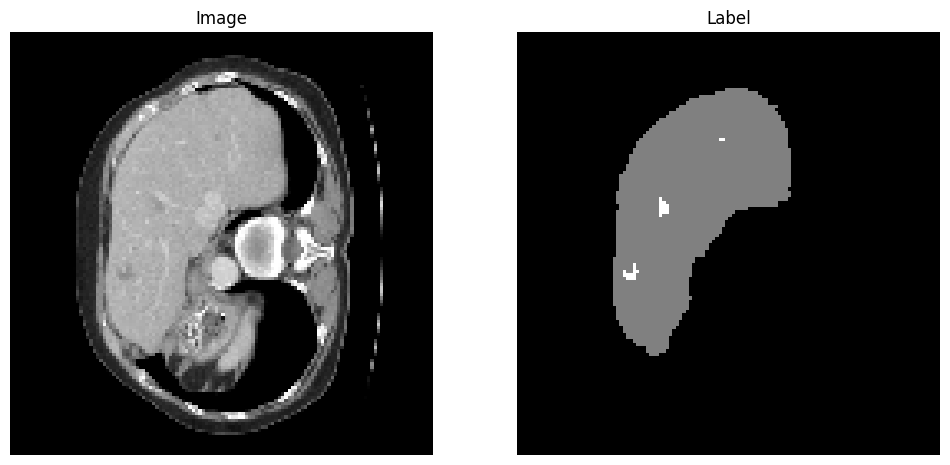

In [28]:

for images, labels in loader:
    image = images[0]
    label = labels[0]
    print(image.shape, label.shape)
    print(image.dtype, label.dtype)
    print(image.min(), image.max())
    print(label.min(), label.max())
    # print(image.unique())
    print(label.unique())

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label.squeeze(), cmap='gray')
    plt.title('Label')
    plt.axis('off')

    plt.show()
    break


In [29]:
model = UNetTestModel()


trainerTest = L.Trainer(max_epochs=200)
trainerTest.fit(model, train_dataloaders=loader, val_dataloaders=val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s] 
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Unet               | 32.5 M
1 | loss_fn        | FocalLoss          | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | Dice           | Dice               | 0     
------------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.060   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.


In [30]:
model.eval()

UNetTestModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

mask unique: tensor([0, 1, 2])
prediction unique: tensor([0, 1, 2])
prediction shape: torch.Size([1, 128, 128])


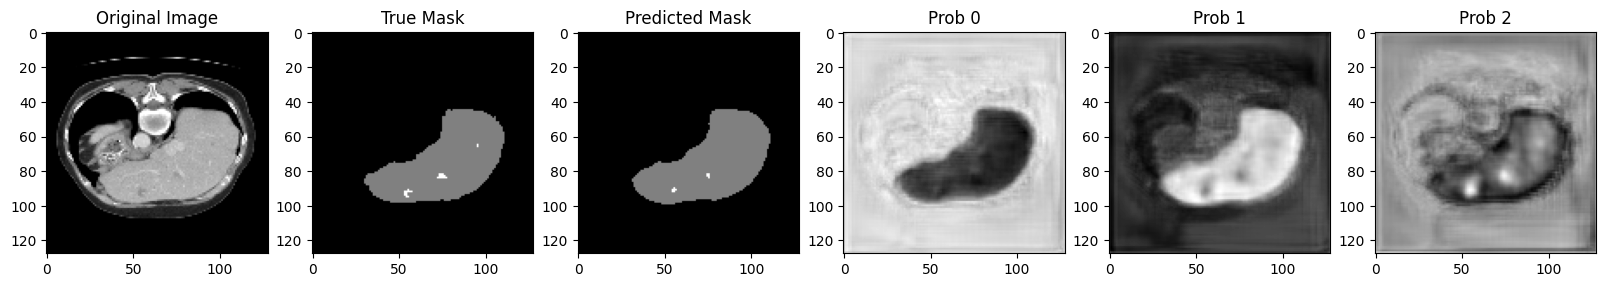

In [31]:
import matplotlib.pyplot as plt
import torch

batch = next(iter(loader))
images, masks = batch


image = images[0].unsqueeze(0)  
mask = masks[0]


device = next(model.parameters()).device  
image = image.to(device)


with torch.no_grad():
    pred = model(image)
    prediction = torch.argmax(pred, dim=1).cpu()  


fig, axs = plt.subplots(1, 6, figsize=(20, 5))
axs[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(mask.cpu().numpy(), cmap='gray')
axs[1].set_title('True Mask')
print(f'mask unique: {torch.unique(mask)}')

axs[2].imshow(prediction[0].numpy(), cmap='gray')
axs[2].set_title('Predicted Mask')
print(f'prediction unique: {torch.unique(prediction)}')
print(f'prediction shape: {prediction.shape}')

axs[3].imshow(pred[0][0].numpy(), cmap='gray')
axs[3].set_title('Prob 0')
axs[4].imshow(pred[0][1].numpy(), cmap='gray')
axs[4].set_title('Prob 1')
axs[5].imshow(pred[0][2].numpy(), cmap='gray')
axs[5].set_title('Prob 2')
plt.show()